In [63]:
import sys
sys.path.insert(0,'../scripts')

In [64]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from joblib import dump
pd.set_option('max_column', None)
pd.set_option('display.float_format', '{:.2f}'.format)
%matplotlib inline

In [65]:
from load_data import loader
import sql_utils as sql
from Result_picker import picker

In [66]:
res = picker()

# Engagement score of each user

In [67]:
engagement_centroids = pd.read_csv('../data/engagement_centroid.csv')
engagement_centroids = engagement_centroids.iloc[:,1:]
engagement_centroids

,Bearer Id,Total Duration (hr),Total Data (MegaBytes)
0,145.79,106.46,144.66
1,1.03,1.16,1.03
2,-0.34,-0.41,-0.34
3,2.06,2.84,2.07
4,0.17,0.20,0.17


In [87]:
engagement_metrics = pd.read_csv('../data/engagement_cluster.csv')
engagement_metrics.index = engagement_metrics['MSISDN/Number']
engagement_metrics = engagement_metrics.iloc[:,1:4]
engagement_metrics.head()

,Bearer Id,Total Duration (hr),Total Data (MegaBytes)
MSISDN/Number,,,
33601001722.00,-0.12,-0.10,0.11
33601001754.00,-0.12,0.12,-0.32
33601002511.00,-0.12,-0.04,-0.06
33601007832.00,-0.12,-0.33,-0.16
33601008617.00,0.18,-0.38,0.45


In [92]:
engagement_score = euclidean_distances(engagement_metrics.values.tolist(),[engagement_centroids.values.tolist()[0]])
engagement_score

array([[231.38738809],
       [231.55088615],
       [231.46246656],
       ...,
       [230.4293563 ],
       [231.27513087],
       [230.47554266]])

In [93]:
engagement_score = [val[0] for val in engagement_score.tolist()]
engagement_score[:2]

[231.3873880913362, 231.55088615150737]

# Experience 

In [94]:
experience_centroids = pd.read_csv('../data/engagement_centroid.csv')
experience_centroids = experience_centroids.iloc[:,1:]
experience_centroids

,Bearer Id,Total Duration (hr),Total Data (MegaBytes)
0,145.79,106.46,144.66
1,1.03,1.16,1.03
2,-0.34,-0.41,-0.34
3,2.06,2.84,2.07
4,0.17,0.20,0.17


In [99]:
experience_metrics = pd.read_csv('../data/experience_cluster.csv')
experience_metrics.index = experience_metrics['MSISDN/Number']
experience_metrics = experience_metrics.iloc[:106856,1:4]
experience_metrics.head()

,Avg Delay (ms),Avg Throughput (kbps),cluster
MSISDN/Number,,,
33601001722.00,-0.34,-0.54,1
33601001754.00,0.52,-0.54,2
33601002511.00,-0.23,-0.54,1
33601007832.00,-0.23,-0.53,1
33601008617.00,-0.23,-0.54,1


In [107]:
experience_score = euclidean_distances(experience_metrics.values.tolist(),[experience_centroids.values.tolist()[0]])
experience_score

array([[231.1697678 ],
       [230.00832063],
       [231.10096659],
       ...,
       [231.10096659],
       [231.21656219],
       [231.53241121]])

In [108]:
experience_score = [val[0] for val in experience_score.tolist()]
experience_score[:2]

[231.1697677999321, 230.00832063158995]

# Satisfing score based on engagement and experience

In [110]:
df = pd.DataFrame()
df['engagement_score'] = engagement_score
df['experience_score'] = experience_score
df.index = engagement_metrics.index
#result
df.head()

,engagement_score,experience_score
MSISDN/Number,,
33601001722.00,231.39,231.17
33601001754.00,231.55,230.01
33601002511.00,231.46,231.10
33601007832.00,231.66,231.10
33601008617.00,231.11,231.10


In [111]:
#taking the average of engagement and experience for satisfaction score
df['satisfaction_score'] = (df['engagement_score'] + df['experience_score'])/2
df.head()

,engagement_score,experience_score,satisfaction_score
MSISDN/Number,,,
33601001722.00,231.39,231.17,231.28
33601001754.00,231.55,230.01,230.78
33601002511.00,231.46,231.10,231.28
33601007832.00,231.66,231.10,231.38
33601008617.00,231.11,231.10,231.11


# Top 10 satisfied customers

In [112]:
#enjecting this satisfaction score to group the customers as most satisfied
top10 = df.sort_values(by='satisfaction_score', ascending=False).iloc[:10,:]
top10.to_csv('../data/top10_satisfied_customers.csv')
top10

,engagement_score,experience_score,satisfaction_score
MSISDN/Number,,,
33663706799.00,280.04,231.10,255.57
33777966807.00,231.57,232.28,231.92
33661041737.00,231.52,232.28,231.90
33660727459.00,231.72,232.07,231.89
33667938958.00,231.82,231.95,231.88
33669466195.00,231.82,231.95,231.88
33650546421.00,231.79,231.97,231.88
33601974265.00,231.81,231.95,231.88
33777259497.00,231.80,231.95,231.87


# predicting the satisfaction of a customer

In [118]:
#using regression model
train_df = engagement_metrics.copy(deep=True)
#train_df['Average TCP'] = experience_metrics['Average TCP'].to_list()
#train_df['Average RTT'] = experience_metrics['Average RTT'].to_list()
train_df['Average throughput'] = experience_metrics['Avg Throughput (kbps)'].to_list()
# Adding our average satisfaction score (this is going to be our predicted value)
train_df['satisfaction_score'] = df['satisfaction_score'].to_list()
train_df.head()

,Bearer Id,Total Duration (hr),Total Data (MegaBytes),Average throughput,satisfaction_score
MSISDN/Number,,,,,
33601001722.00,-0.12,-0.10,0.11,-0.54,231.28
33601001754.00,-0.12,0.12,-0.32,-0.54,230.78
33601002511.00,-0.12,-0.04,-0.06,-0.54,231.28
33601007832.00,-0.12,-0.33,-0.16,-0.53,231.38
33601008617.00,0.18,-0.38,0.45,-0.54,231.11


In [120]:
#dividing the data as 80 train and 20 test
train_data = train_df.iloc[:int(len(train_df) * 0.8),:]
test_data = train_df.iloc[int(len(train_df) * 0.8):,:]

In [121]:
train_x = train_data.iloc[:,:-1]
train_y = train_data.iloc[:,-1:]


In [122]:
test_x = test_data.iloc[:,:-1]
test_y = test_data.iloc[:,-1:]

In [123]:
xtrain,xtest,ytrain,ytest = train_test_split(train_x,train_y,test_size=0.2,random_state=40)

In [124]:
alpha_val = 0.8
rr = Ridge(alpha=alpha_val)
rr.fit(xtrain, ytrain)
# Validation value of the model
validation_score = rr.score(xtest, ytest)
print("The model score is: {:.5f}".format(validation_score))

The model score is: 0.64645


In [125]:
rr.fit(train_x, train_y)
# Test on the test data
final_score = rr.score(test_x,test_y)
print("The model final score is: {:.5f}".format(final_score))

The model final score is: 0.65694


In [127]:
model_desc = {'Model Name': "Ridge Model",'alpha':alpha_val,'Validation score': validation_score, 'Test Score': final_score}
#Saving the model data
res.add_data('model_desc',model_desc)
#result
model_desc

{'Model Name': 'Ridge Model',
 'alpha': 0.8,
 'Validation score': 0.6464483226431829,
 'Test Score': 0.6569418647742722}

In [129]:
# Saving the final Model using joblibs 
dump(rr, '../data/satisfaction_scorer_model.joblib')

['../data/satisfaction_scorer_model.joblib']

# clustering users based on engagement and experience

In [131]:
cluster_df = df.iloc[:,:2]
cluster_df.head()

,engagement_score,experience_score
MSISDN/Number,,
33601001722.00,231.39,231.17
33601001754.00,231.55,230.01
33601002511.00,231.46,231.10
33601007832.00,231.66,231.10
33601008617.00,231.11,231.10


In [132]:
# Creating a k-means cluster with 2 number of clusters
km = KMeans(init="random",n_clusters=2,n_init=10,max_iter=300,random_state=42)
label = km.fit_predict(cluster_df)
centroids = km.cluster_centers_
print(f'# Centroids of the clustering:\n{centroids}')
print(f'# The number of iterations required to converge: {km.inertia_}')
print(f'# The number of iterations required to converge: {km.n_iter_}')

# Centroids of the clustering:
[[231.33685125 231.20766914]
 [231.33670696 229.01984538]]
# The number of iterations required to converge: 56463.53095468903
# The number of iterations required to converge: 6


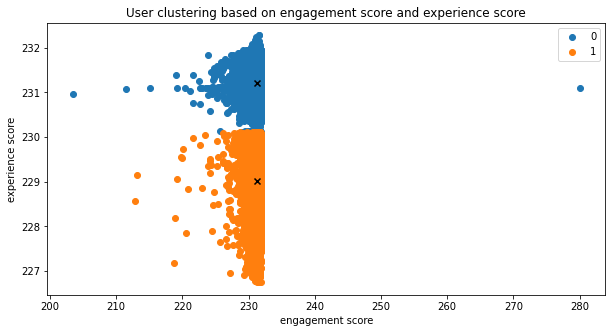

In [133]:
u_labels = np.unique(label)
 
#plotting the results:
plt.figure(figsize=(10,5))
plt.title(f'User clustering based on engagement score and experience score')
for i in u_labels:
    plt.scatter(cluster_df[label == i].iloc[:,0] , cluster_df[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1], marker='x', color = 'black')
plt.xlabel("engagement score")
plt.ylabel("experience score")
plt.legend()
plt.savefig('../data/satisfaction_cluster.png')
plt.show()

In [134]:
# Attaching the cluster index from the previous clustering using the label data
agg_df = df.copy(deep=True)
agg_df['cluster'] = label
agg_df

,engagement_score,experience_score,satisfaction_score,cluster
MSISDN/Number,,,,
33601001722.00,231.39,231.17,231.28,0
33601001754.00,231.55,230.01,230.78,1
33601002511.00,231.46,231.10,231.28,0
33601007832.00,231.66,231.10,231.38,0
33601008617.00,231.11,231.10,231.11,0
...,...,...,...,...
33789996170.00,231.62,231.10,231.36,0
33789997247.00,231.50,231.36,231.43,0
3197020876596.00,230.43,231.10,230.77,0


In [136]:
agg_columns = {'engagement_score':'mean','experience_score':'mean','satisfaction_score':'mean'}
#Group and Aggregate
agg_df =agg_df.groupby('cluster').agg(agg_columns)
#Saving the data
res.add_data('statisfaction_agg_cluster',agg_df)
#result
agg_df

,engagement_score,experience_score,satisfaction_score
cluster,,,
0,231.34,231.21,231.27
1,231.34,229.02,230.18
